In [2]:
# run this on sheet1 to get the DOIs
# just change the file names in the third to last line and the last line
from habanero import Crossref
import metadata_parser,pikepdf,requests
from io import BytesIO
import pandas as pd
from bs4 import BeautifulSoup
from crossref_commons import retrieval
from tqdm.auto import tqdm
import pdftitle,pdf2doi,doi

tqdm.pandas()
def get_metadata(url):
    try:
        page=metadata_parser.MetadataParser(url)
        return page.metadata['og']
    except:
        return {}
def nex(url,pos,symbols):
    return min([url.find(s,pos) if s in url[pos:] else len(url) for s in symbols])
def get_DOI(row):
    try:
        if doi.validate_doi(row.DOI)!=None:
            return row.DOI
    except:
        pass
    try:
        # title=row["Algorithm Name"]
        url=row["Paper/Reference Link"]
        if doi.find_doi_in_text(url)!=None:
            return doi.find_doi_in_text(url)
        if "10." in url:
            pos=url.find("10.")
            DOI=url[pos:nex(url,pos,"?&")]
            return DOI
        if "acm" in url:
            return ""
        if url[:21]=="https://arxiv.org/pdf":
            url=url[:18]+"abs"+url[21:-4]
        if url[:33]=="https://ieeexplore.ieee.org/stamp":
            url="https://ieeexplore.ieee.org/abstract/document/"+url[url.rfind("=")+1:]
        response=requests.get(url,headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
        if "pdf" in url:
            with open('./tmp.pdf','wb') as f:
                f.write(response.content)
            return doi.pdf_to_doi("tmp.pdf")
        else:
            return doi.find_doi_in_text(response.text)
            """ if title!="":
                cr=Crossref()
                result=cr.works(query=title)
                DOI=result['message']['items'][0]['DOI']
            if DOI in response.text:
                return DOI """
    except:
        pass
    return ""
def get_title_from_url(url):
    try:
        if "10." in url:
            DOI=url[url.find("10."):url.rfind("?") if "?" in url else len(url)]
            return retrieval.get_publication_as_json(DOI)['title'][0]
        if "acm" in url:
            return ""
        if url[:21]=="https://arxiv.org/pdf":
            url=url[:18]+"abs"+url[21:-4]
        if url[:33]=="https://ieeexplore.ieee.org/stamp":
            url="https://ieeexplore.ieee.org/abstract/document/"+url[url.rfind("=")+1:]
        response=requests.get(url,headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
        if "pdf" in url:
            pdf=pikepdf.Pdf.open(BytesIO(response.content))
            metadata=pdf.docinfo
            if "\Title" in metadata:
                return metadata["\Title"]
            return pdftitle.get_title_from_io(BytesIO(response.content))
        else:
            soup=BeautifulSoup(response.text,"html.parser")
            if soup.findAll("title"):
                return soup.find("title").string
    except:
        pass
    return ""
def bad(title):
    return title in ["nan","Just a moment...","Redirecting","ACM Error: IP blocked"]
pdf2doi.config.set("save_identifier_metadata",False)
pdf2doi.config.set("verbose",False)
data=pd.read_csv("AlgoWiki algorithms (our copy) - Sheet1.csv")
data["DOI"]=data.progress_apply(get_DOI,axis=1)
data.to_csv("authors_dataset_doi.csv",index=False)

100%|██████████| 1040/1040 [13:18<00:00,  1.30it/s] 


In [137]:
# this cell takes the last output file as an input and scrapes the author names, the number or authors, and the year from the DOIs
# just change the two file names in the main method
import pandas as pd
import requests
import datetime

def scrape_details(DOI):
    authors = []
    num_authors = 0
    title = ''
    date = None
    year = None
    url = ''
    link = 'https://api.crossref.org/works/' + str(DOI)
    response = requests.get(link)
    if response.status_code == 200:
        data = response.json()
        if 'author' in data['message']:
            for author in data['message']['author']:
                if 'given' in author and 'family' in author:
                    authors.append(author['given'] + ' ' + author['family'])
                elif 'family' in author:
                    authors.append(author['family'])
                elif 'given' in author:
                    authors.append(author['given'])
                num_authors = len(authors)
                title = data['message']['title']
                if 'published' in data['message']:
                    date = data['message']['published']['date-parts'][0]
                else:
                    date = data['message']['created']['date-parts'][0]
                year = date[0]
                url = data['message']['resource']['primary']['URL']
        elif 'editor' in data['message']:
            for author in data['message']['editor']:
                authors.append(author['given'] + ' ' + author['family'])
                num_authors = len(authors)
                title = data['message']['title']
                date = data['message']['created']['date-parts'][0]
                year = date[0]
                month = date[1]
                day = date[2]
                date = datetime.date(int(year), int(month), int(day)).strftime('%m/%d/%Y')
                url = data['message']['resource']['primary']['URL']
    return authors, num_authors, title, url

def read_csv(infile):
    df = pd.read_csv(infile)
    for index, row in df.iterrows():
        df[['Authors', 'Number of Authors', 'Title', 'Date', 'URL']] = df['DOI'].apply(scrape_details).apply(pd.Series)
    return df

def main():
    df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset_doi.csv')
    new_list_dict = []
    for index, row in df.iterrows():
        doi = row['DOI']
        algorithm = row['Algorithm Name']
        authors, num_authors, title, url = scrape_details(doi)
        
        # Append the scraped details to the new DataFrame
        new_list_dict.append({
            'Authors': authors,
            'Number of Authors': num_authors,
            'Title': title,
            'URL': url
        })
    # Save the new DataFrame to a CSV file
    new_df = pd.DataFrame(new_list_dict)
    merged_df = pd.merge(df, new_df, left_index=True, right_index=True)
    merged_df.to_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv', index=False)

if __name__ == "__main__":
    main()

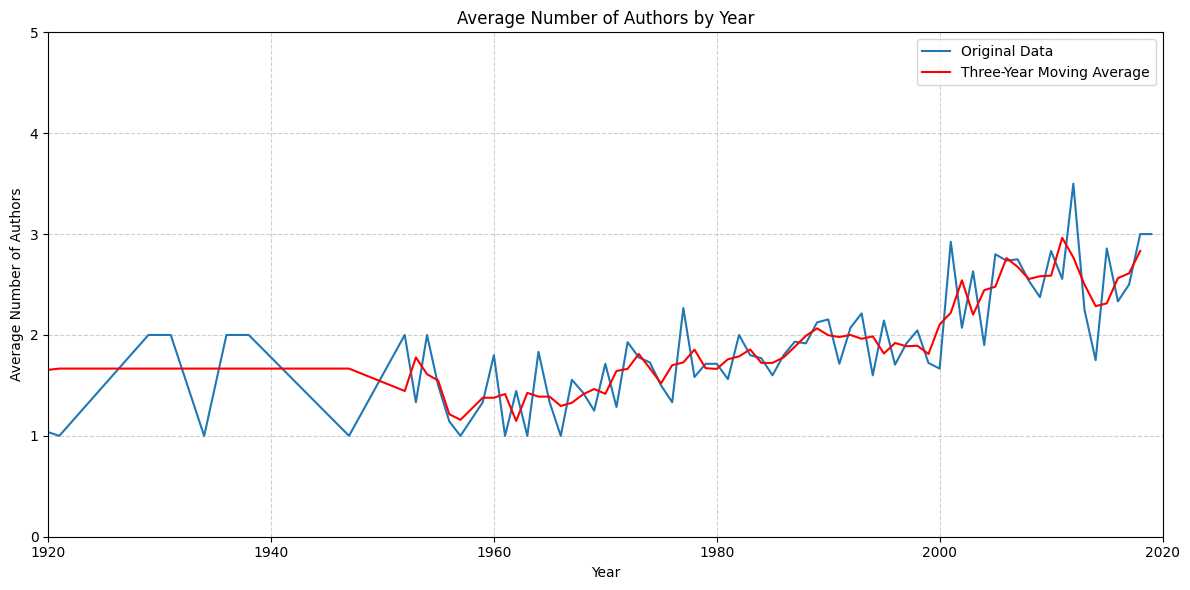

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')
df_filtered = df[df['Number of Authors'] != 0] # Filter out zeros where authors weren't found
avg_authors_by_year = df_filtered.groupby('Year')['Number of Authors'].mean()

# Calculate and plot the three-year moving average
window_size = 3
moving_avg = avg_authors_by_year.rolling(window=window_size, center=True).mean()

# Plot the original data
ax.plot(avg_authors_by_year.index, avg_authors_by_year.values, label='Original Data')
ax.set_xlabel('Year')
ax.set_ylabel('Average Number of Authors')
ax.set_title('Average Number of Authors by Year')
ax.set_xlim(1920, 2020)
ax.set_ylim(0, 5)

# Plot the three-year moving average on top
ax.plot(moving_avg.index, moving_avg.values, label='Three-Year Moving Average', color='red')

# Add horizontal grid lines
ax.grid(True, linestyle='--', alpha=0.6)

# Add a legend
ax.legend()

plt.tight_layout()
plt.show()

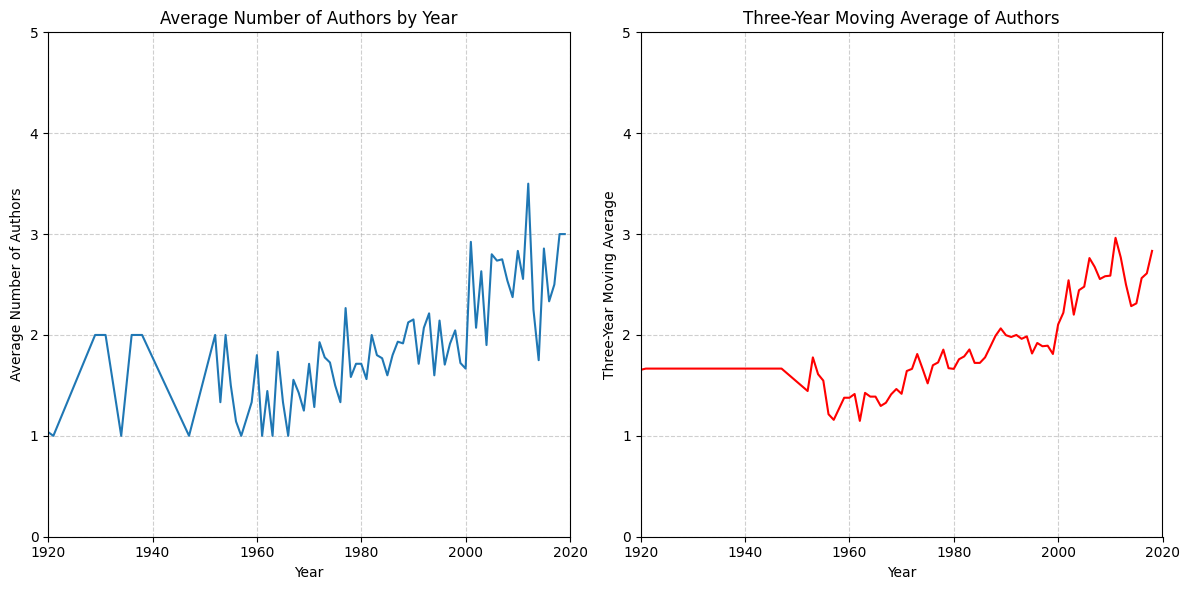

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')
df_filtered = df[df['Number of Authors'] != 0] # Filter out zeros where authors weren't found
avg_authors_by_year = df_filtered.groupby('Year')['Number of Authors'].mean()
axes[0].plot(avg_authors_by_year.index, avg_authors_by_year.values)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Number of Authors')
axes[0].set_title('Average Number of Authors by Year')
axes[0].set_xlim(1920, 2020)
axes[0].set_ylim(0, 5)

# Calculate and plot the three-year moving average
window_size = 3
moving_avg = avg_authors_by_year.rolling(window=window_size, center=True).mean()
axes[1].plot(moving_avg.index, moving_avg.values, color='red')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Three-Year Moving Average')
axes[1].set_title('Three-Year Moving Average of Authors')
axes[1].set_xlim(1920, 2020)
axes[1].set_ylim(0, 5)

# Add horizontal grid lines to both subplots
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

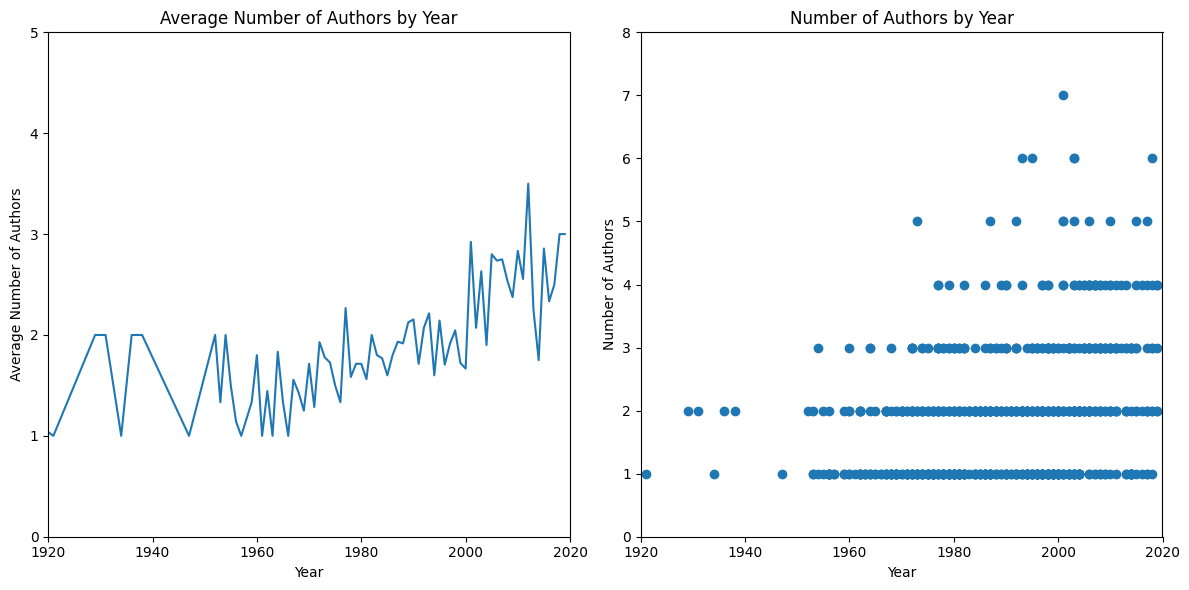

In [152]:
# average number of authors per year chart
# number of authors over time scatter plot
# just change infile name

import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')
df_filtered = df[df['Number of Authors'] != 0] #filter out zeros where authors weren't found
avg_authors_by_year = df_filtered.groupby('Year')['Number of Authors'].mean()
axes[0].plot(avg_authors_by_year.index, avg_authors_by_year.values)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Number of Authors')
axes[0].set_title('Average Number of Authors by Year')
axes[0].set_xlim(1920, 2020)
axes[0].set_ylim(0, 5)

axes[1].scatter(df_filtered.Year, df_filtered['Number of Authors'])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Authors')
axes[1].set_title('Number of Authors by Year')
axes[1].set_xlim(1920, 2020)
axes[1].set_ylim(0, 8)

plt.tight_layout()
plt.show()

/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/25646565.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time.drop(df_time[df_time['Time Complexity Class'].isnull()].index, inplace=True)
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/25646565.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time.drop(df_time[df_time['Time Complexity Class'] == '#VALUE!'].index, inplace=True)
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/25646565.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

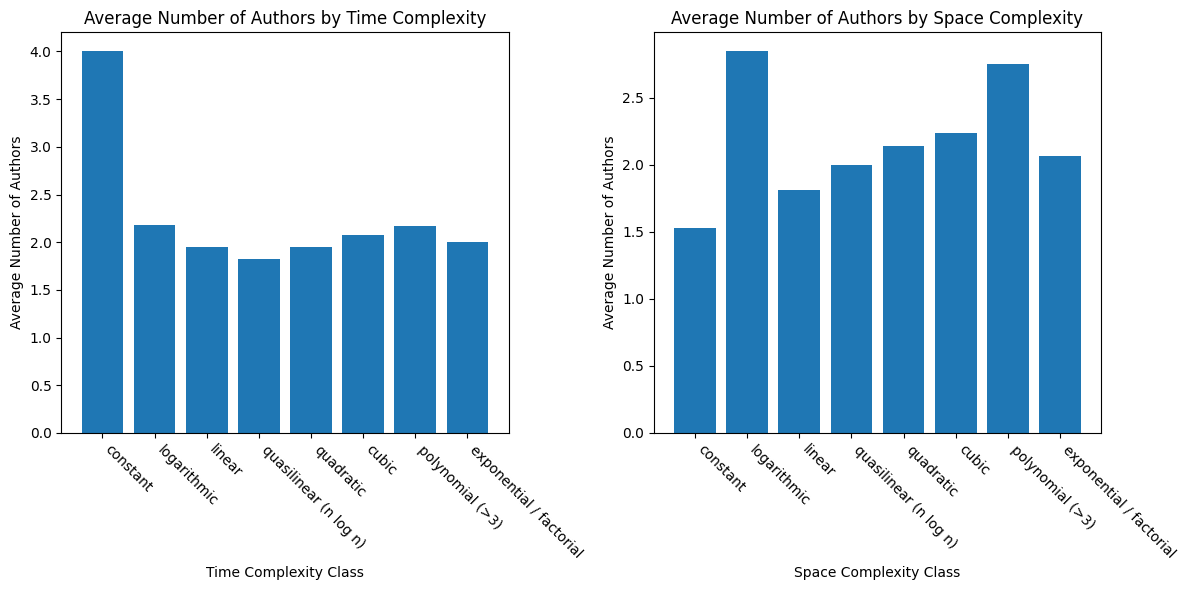

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')
df_time = df[df['Number of Authors'] != 0]
df_time.drop(df_time[df_time['Time Complexity Class'].isnull()].index, inplace=True)
df_time.drop(df_time[df_time['Time Complexity Class'] == '#VALUE!'].index, inplace=True)
df_time['Time Complexity Class'] = df_time['Time Complexity Class'].astype(float).round()
avg_authors_by_time_complexity = df_time.groupby('Time Complexity Class')['Number of Authors'].mean()

df_space = df[df['Number of Authors'] != 0]
df_space.drop(df_space[df_space['Space Complexity Class'].isnull()].index, inplace=True)
df_space.drop(df_space[df_space['Space Complexity Class'] == '#VALUE!'].index, inplace=True)
df_space['Space Complexity Class'] = df_space['Space Complexity Class'].astype(float).round()
avg_authors_by_space_complexity = df_space.groupby('Space Complexity Class')['Number of Authors'].mean()


custom_xticks = [1,2,3,4,5,6,7,8]
custom_xtick_labels = ['constant','logarithmic','linear','quasilinear (n log n)','quadratic','cubic','polynomial (>3)','exponential / factorial']

axes[0].bar(avg_authors_by_time_complexity.index, avg_authors_by_time_complexity.values)
axes[0].set_xlabel('Time Complexity Class')
axes[0].set_ylabel('Average Number of Authors')
axes[0].set_title('Average Number of Authors by Time Complexity')
axes[0].set_xticks(custom_xticks, custom_xtick_labels, rotation = -45, ha='left')

axes[1].bar(avg_authors_by_space_complexity.index, avg_authors_by_space_complexity.values)
axes[1].set_xlabel('Space Complexity Class')
axes[1].set_ylabel('Average Number of Authors')
axes[1].set_title('Average Number of Authors by Space Complexity')
axes[1].set_xticks(custom_xticks, custom_xtick_labels, rotation = -45, ha='left')

plt.tight_layout()
plt.show()

/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/208994496.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time.dropna(subset=['Time Complexity Class'], inplace=True)
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/208994496.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['Time Complexity Class'] = df_time['Time Complexity Class'].str.replace('#VALUE!', 'NaN').astype(float).round()
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/208994496.py:17: SettingWithCopyWarning: 
A value is trying to be

Time Complexity Class
1.0    4.000000
2.0    2.185185
3.0    1.948905
4.0    1.820000
5.0    1.954545
6.0    2.080357
7.0    2.166667
8.0    2.000000
Name: Number of Authors, dtype: float64
Time Complexity Class
1.0         NaN
2.0    0.962250
3.0    1.126689
4.0    0.914308
5.0    1.094496
6.0    1.032258
7.0    1.108409
8.0    0.939000
Name: Number of Authors, dtype: float64
Space Complexity Class
1.0    1.526316
2.0    2.843750
3.0    1.810997
4.0    2.000000
5.0    2.140845
6.0    2.235294
7.0    2.750000
8.0    2.060606
Name: Number of Authors, dtype: float64
Space Complexity Class
1.0    0.682616
2.0    1.461536
3.0    0.918403
4.0    0.925820
5.0    1.108264
6.0    1.147247
7.0    1.258306
8.0    0.933387
Name: Number of Authors, dtype: float64


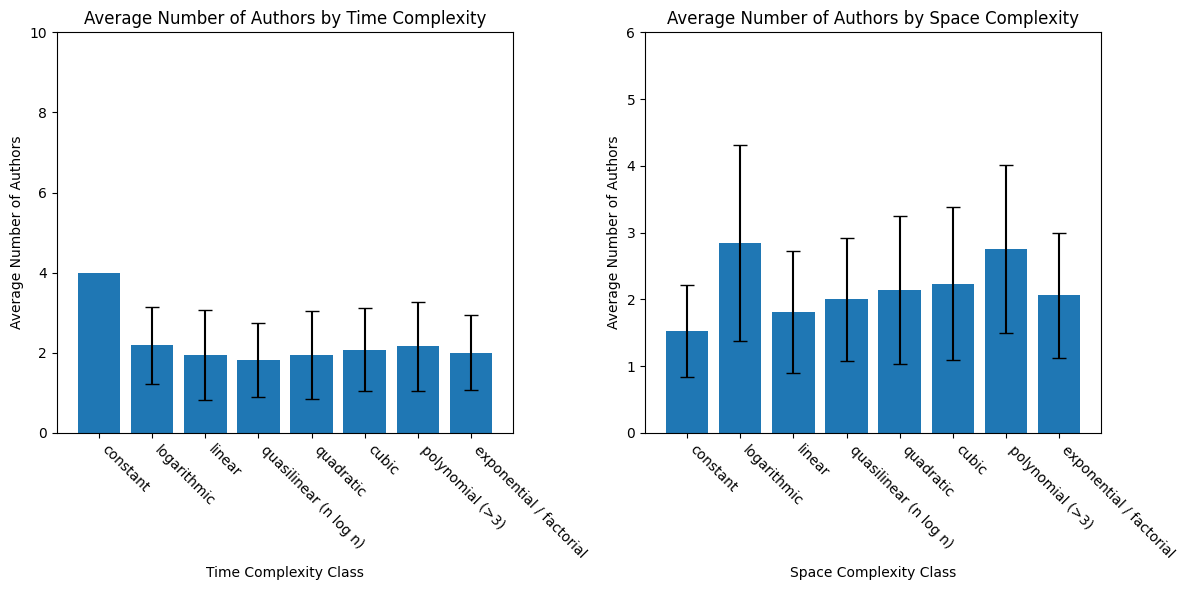

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')

# Filter and preprocess the data for time complexity
df_time = df[df['Number of Authors'] != 0]
df_time.dropna(subset=['Time Complexity Class'], inplace=True)
df_time['Time Complexity Class'] = df_time['Time Complexity Class'].str.replace('#VALUE!', 'NaN').astype(float).round()
avg_authors_by_time_complexity = df_time.groupby('Time Complexity Class')['Number of Authors'].mean()
std_authors_by_time_complexity = df_time.groupby('Time Complexity Class')['Number of Authors'].std()

# Filter and preprocess the data for space complexity
df_space = df[df['Number of Authors'] != 0]
df_space.dropna(subset=['Space Complexity Class'], inplace=True)
df_space['Space Complexity Class'] = df_space['Space Complexity Class'].str.replace('#VALUE!', 'NaN').astype(float).round()
avg_authors_by_space_complexity = df_space.groupby('Space Complexity Class')['Number of Authors'].mean()
std_authors_by_space_complexity = df_space.groupby('Space Complexity Class')['Number of Authors'].std()

print(avg_authors_by_time_complexity)
print(std_authors_by_time_complexity)

print(avg_authors_by_space_complexity)
print(std_authors_by_space_complexity)

custom_xticks = [1, 2, 3, 4, 5, 6, 7, 8]
custom_xtick_labels = ['constant', 'logarithmic', 'linear', 'quasilinear (n log n)', 'quadratic', 'cubic', 'polynomial (>3)', 'exponential / factorial']

# Plot for Time Complexity
axes[0].bar(avg_authors_by_time_complexity.index, avg_authors_by_time_complexity.values, yerr=std_authors_by_time_complexity.values, capsize=5)
axes[0].set_xlabel('Time Complexity Class')
axes[0].set_ylabel('Average Number of Authors')
axes[0].set_title('Average Number of Authors by Time Complexity')
axes[0].set_ylim(0, 10)
axes[0].set_xticks(custom_xticks, custom_xtick_labels, rotation=-45, ha='left')

# Plot for Space Complexity
axes[1].bar(avg_authors_by_space_complexity.index, avg_authors_by_space_complexity.values, yerr=std_authors_by_space_complexity.values, capsize=5)
axes[1].set_xlabel('Space Complexity Class')
axes[1].set_ylabel('Average Number of Authors')
axes[1].set_title('Average Number of Authors by Space Complexity')
axes[1].set_ylim(0, 6)
axes[1].set_xticks(custom_xticks, custom_xtick_labels, rotation=-45, ha='left')

plt.tight_layout()
plt.show()


In [3]:
# show that authors and time complexity are not significant (0.9 standard deviations away)
# show that authors and space complexity are not significant (1.68 standard deviations away)

In [ ]:
# number of authors for first vs third paper normalized to a year

In [ ]:
# number of authors for algorithms that are asymptotically optimal

In [ ]:
# average number of years between papers that improve an algorithm against number of authors on the paper

/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/2784784238.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['Time Complexity Class'], inplace=True)
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/2784784238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Time Complexity Class'] = df_filtered['Time Complexity Class'].str.replace('#VALUE!', 'NaN').astype(float).round()


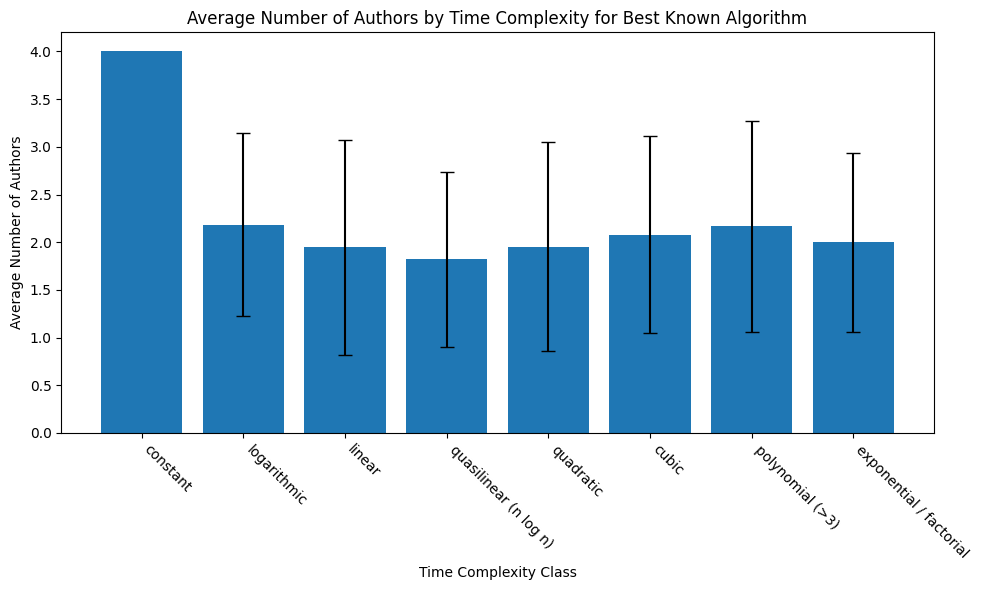

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')

# Filter and preprocess the data
df_filtered = df[df['Number of Authors'] != 0]
df_filtered.dropna(subset=['Time Complexity Class'], inplace=True)
df_filtered['Time Complexity Class'] = df_filtered['Time Complexity Class'].str.replace('#VALUE!', 'NaN').astype(float).round()

# Group data by Time Complexity Class and calculate mean and standard deviation
grouped = df_filtered.groupby('Time Complexity Class')['Number of Authors']
avg_authors_by_time_complexity = grouped.mean()
std_authors_by_time_complexity = grouped.std()

# Define custom x-tick positions and labels
custom_xticks = [1, 2, 3, 4, 5, 6, 7, 8]
custom_xtick_labels = ['constant', 'logarithmic', 'linear', 'quasilinear (n log n)', 'quadratic', 'cubic', 'polynomial (>3)', 'exponential / factorial']

# Create the bar chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(avg_authors_by_time_complexity.index, avg_authors_by_time_complexity.values, yerr=std_authors_by_time_complexity.values, capsize=5)
plt.xlabel('Time Complexity Class')
plt.ylabel('Average Number of Authors')
plt.title('Average Number of Authors by Time Complexity for Best Known Algorithm')
plt.xticks(custom_xticks, custom_xtick_labels, rotation=-45, ha='left')

plt.tight_layout()
plt.show()


/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/2713903703.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time.drop(df_time[df_time['Time Complexity Class'].isnull()].index, inplace=True)
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/2713903703.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time.drop(df_time[df_time['Time Complexity Class'] == '#VALUE!'].index, inplace=True)
/var/folders/w7/lcn8swqx1bq7r1dqcdby_4mc0000gn/T/ipykernel_38140/2713903703.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

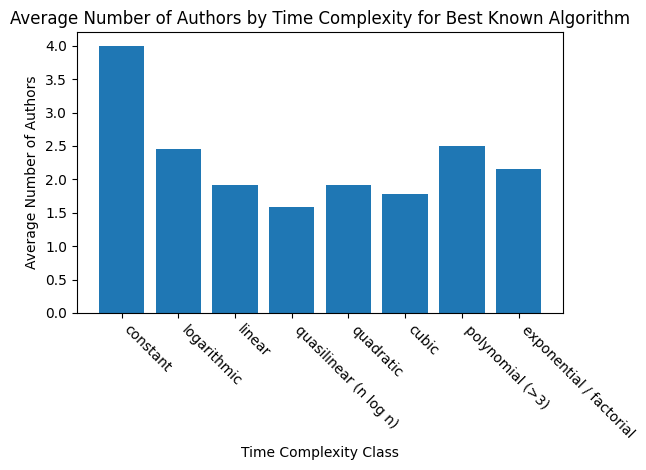

In [157]:
# authors against best known algorithm (correct by trends over years vs regularly running it)
# will need time complexity of best known algorithm
df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')

data = df.to_dict(orient='records')

min_time_complexities = {}

# Iterate through the list of dictionaries and find min time complexity class for each family
for entry in data:
    family_name = entry['Family Name']
    time_complexity_class = entry['Time Complexity Class']
    
    if family_name not in min_time_complexities:
        min_time_complexities[family_name] = time_complexity_class
    else:
        min_time_complexities[family_name] = min(min_time_complexities[family_name], time_complexity_class)
optimal_algos = []
# Iterate through the list of dictionaries and add the min_time_complexity_class to each entry
for entry in data:
    family_name = entry['Family Name']
    entry['min_time_complexity_class'] = min_time_complexities[family_name]
    if entry['min_time_complexity_class'] == entry['Time Complexity Class']:
        optimal_algos.append(entry)

df = pd.DataFrame(optimal_algos)
df_time = df[df['Number of Authors'] != 0]
df_time.drop(df_time[df_time['Time Complexity Class'].isnull()].index, inplace=True)
df_time.drop(df_time[df_time['Time Complexity Class'] == '#VALUE!'].index, inplace=True)
df_time['Time Complexity Class'] = df_time['Time Complexity Class'].astype(float).round()
avg_authors_by_time_complexity = df_time.groupby('Time Complexity Class')['Number of Authors'].mean()
    
custom_xticks = [1,2,3,4,5,6,7,8]
custom_xtick_labels = ['constant','logarithmic','linear','quasilinear (n log n)','quadratic','cubic','polynomial (>3)','exponential / factorial']

plt.bar(avg_authors_by_time_complexity.index, avg_authors_by_time_complexity.values)
plt.xlabel('Time Complexity Class')
plt.ylabel('Average Number of Authors')
plt.title('Average Number of Authors by Time Complexity for Best Known Algorithm')
plt.xticks(custom_xticks, custom_xtick_labels, rotation = -45, ha='left')

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import statistics
import pandas as pd

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')

data = df.to_dict(orient='records')

best_known_algos = {}

# Iterate through the data and update best_known_algos
for entry in data:
    family_name = entry['Family Name']
    algo_name = entry['Algorithm Name']
    year = entry['Year']
    time_complexity_class = entry['Time Complexity Class']
    
    if family_name not in best_known_algos:
        best_known_algos[family_name] = entry
    else:
        current_best = best_known_algos[family_name]
        if (
            time_complexity_class < current_best['Time Complexity Class']
            or (
                time_complexity_class == current_best['Time Complexity Class']
                and year < current_best['Year']
            )
        ):
            best_known_algos[family_name] = entry

# Convert the dictionary values to a list
best_known_algos = list(best_known_algos.values())

num_authors = []
for problem in best_known_algos:
    if problem['Number of Authors'] != 0 and not np.isnan(problem['Number of Authors']):
        num_authors.append(problem['Number of Authors'])
average = np.mean(num_authors)
standard_dev = statistics.stdev(num_authors)

all_num_authors = []
for problem in data:
    if problem['Number of Authors'] != 0 and not np.isnan(problem['Number of Authors']):
        all_num_authors.append(problem['Number of Authors'])
#print(all_num_authors)
all_average = np.mean(all_num_authors)
all_standard_dev = statistics.stdev(all_num_authors)

print("average number of authors for best known algorithm: " + str(average))
print("standard deviation of number of authors for best known algorithm: " + str(standard_dev))
print("average number of authors: " + str(all_average))
print("standard deviation of number of authors: " + str(all_standard_dev))


average number of authors for best known algorithm: 2.011111111111111
standard deviation of number of authors for best known algorithm: 1.0221638695823925
average number of authors: 1.9811046511627908
standard deviation of number of authors: 1.0425827020593412


In [ ]:
# number of authors against years since last improvement

In [ ]:
# number of authors against papers since last improvement

In [176]:
# create a dataset for the regression
df_authors = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/authors_dataset.csv')
df_wikipedia = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/wikipedia/views.csv')
df = pd.merge(df_authors, df_wikipedia, left_index=True, right_index=True)
df.to_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/regression_data.csv', index=False)


In [194]:
# add years since problem first introduced
df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/regression_data.csv')
data = df.to_dict(orient='records')

oldest_algos = {}

for entry in data:
    family_name = entry['Family Name']
    year = entry['Year']
    if (year > 0) and ((family_name not in oldest_algos) or (year < oldest_algos[family_name])):
        oldest_algos[family_name] = year

for algo in data: 
    family_name = algo['Family Name']
    algo['years_since_problem_introduced'] = 2023 - oldest_algos[family_name]
pd.DataFrame(data).to_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/regression_data.csv', index=False)


In [214]:
# add years since last improvement
import math
df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/regression_data.csv')
data = df.to_dict(orient='records')

last_improvement_year = {}

for entry in data: 
    family_name = entry['Family Name']
    year = entry['Year']
    time_complexity_class = entry['Time Complexity Class']
    if family_name not in last_improvement_year:
        last_improvement_year[family_name] = [year, time_complexity_class]
    elif last_improvement_year[family_name][1] > time_complexity_class:
        last_improvement_year[family_name] = [year, time_complexity_class]
    elif (last_improvement_year[family_name][1] == time_complexity_class) and (last_improvement_year[family_name][0] > year):
        last_improvement_year[family_name] = [year, time_complexity_class]

for algo in data: 
    family_name = algo['Family Name']
    algo['years_since_last_improvement'] = 2023 - last_improvement_year[family_name][0]

keys_to_extract = ['Family Name', 'Algorithm Name', 'Year', 'Time Complexity Class', 'average_monthly_reads', 'years_since_problem_introduced', 'years_since_last_improvement', 'Number of Authors']

new_list = [
    {key: (d[key] if key != 'average_monthly_reads' else 0 if math.isnan(d[key]) else d[key])
     for key in keys_to_extract}
    for d in data
    if d.get('Time Complexity Class') != '#VALUE!' and d.get('Number of Authors', 0) != 0
]

pd.DataFrame(new_list).to_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/regression_data.csv', index=False)    

In [ ]:
# add gap between complexity class of algo and lower bound

In [216]:
# reg num authors on algo year, years since problem first introduced, years since last improvement, complexity class of algo, gap between complexity class of algo and lower bound, wikipedia page views
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

df = pd.read_csv('/Users/bellasteedly/Library/Mobile Documents/com~apple~CloudDocs/AlgorithmsWiki/authors/regression_data.csv')

X = df[['Year', 'years_since_problem_introduced', 'years_since_last_improvement', 'Time Complexity Class', 'average_monthly_reads']]
X = sm.add_constant(X)  # Add a constant for the intercept
Y = df['Number of Authors']

model = LinearRegression()
model.fit(X, Y)
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)
predictions = model.predict(X)
r_squared = r2_score(y, predictions)
print("R-squared:", r_squared)

Coefficients: [ 0.00000000e+00  8.26570606e-04 -6.35062265e-04 -1.12601801e-05
 -7.11464311e-03 -6.56905993e-06]
Intercept: -0.1371627104191515


ValueError: Found input variables with inconsistent numbers of samples: [1040, 996]